# Split dataset and create balanced training dataset
This notebook creates trainig dataset by agumentation and color conversions for model2.<br>

Input file: "masked/df.csv"<br>
Output file: "working/train_df.csv", "working/valid_df.csv", "working/test_df.csv"<br>
Number of training data: 49,000

In [35]:
import numpy as np
import pandas as pd
import os
import math
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import PIL
from PIL import Image

import skimage
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb

from mpl_toolkits.mplot3d import Axes3D

import cv2

import shutil
from tqdm import tqdm
import albumentations as A

In [2]:
# import external codes
%run Colors/Skin_color_functions.ipynb

In [3]:
root = "d:/ham/"
df = pd.read_csv(root + "masked/df.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   filepaths     10015 non-null  object 
 8   cell_type     10015 non-null  object 
 9   labels        10015 non-null  int64  
 10  ita           10015 non-null  float64
 11  ita labels    10015 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 939.0+ KB


In [5]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,ita,ita labels
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0027419...,Benign keratosis-like lesions,2,101.800684,1
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0025030...,Benign keratosis-like lesions,2,103.164404,1
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0026769...,Benign keratosis-like lesions,2,92.573301,1
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0025661...,Benign keratosis-like lesions,2,89.417921,1
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,d:/ham/ham/HAM10000_images_part_2/ISIC_0031633...,Benign keratosis-like lesions,2,96.993318,1


In [6]:
df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,filepaths,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0027419...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


C:\Users\662262\AppData\Local\Temp\ipykernel_13360\1561351173.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


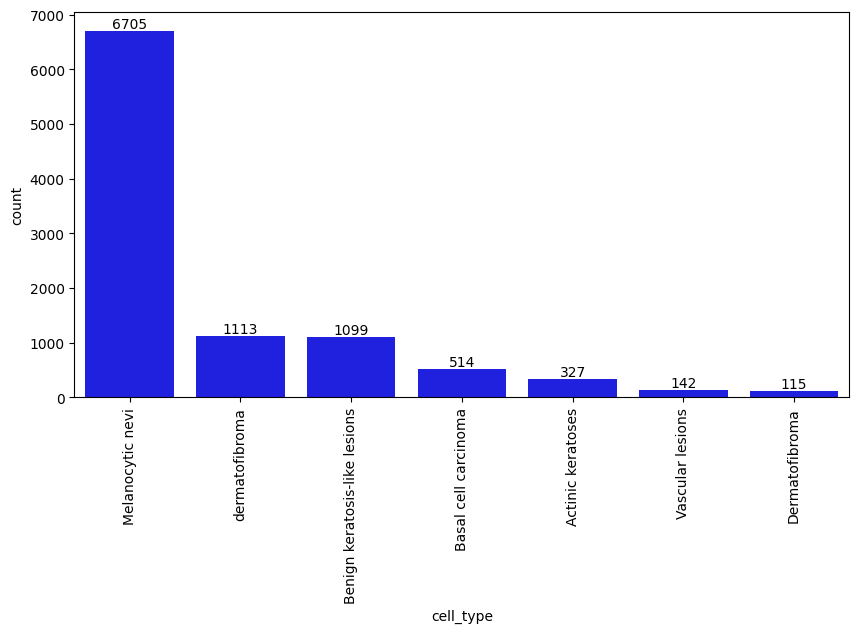

In [7]:
plt.figure(figsize=(10, 5))
ax=sns.countplot(data=df, x="cell_type", order=df["cell_type"].value_counts().index, color="b")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.bar_label(ax.containers[0])
plt.show()

In [8]:
# Rename the columns
new_column_names = {'path': 'filepaths', 'cell_type_idx': 'labels'}
df = df.rename(columns=new_column_names)
df["labels"] = df['labels'].apply(lambda x: str(x))

## Split dataset

In [9]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=42, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=42, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    return train_df, test_df, valid_df    

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  8012   test_df length:  1002   valid_df length:  1001


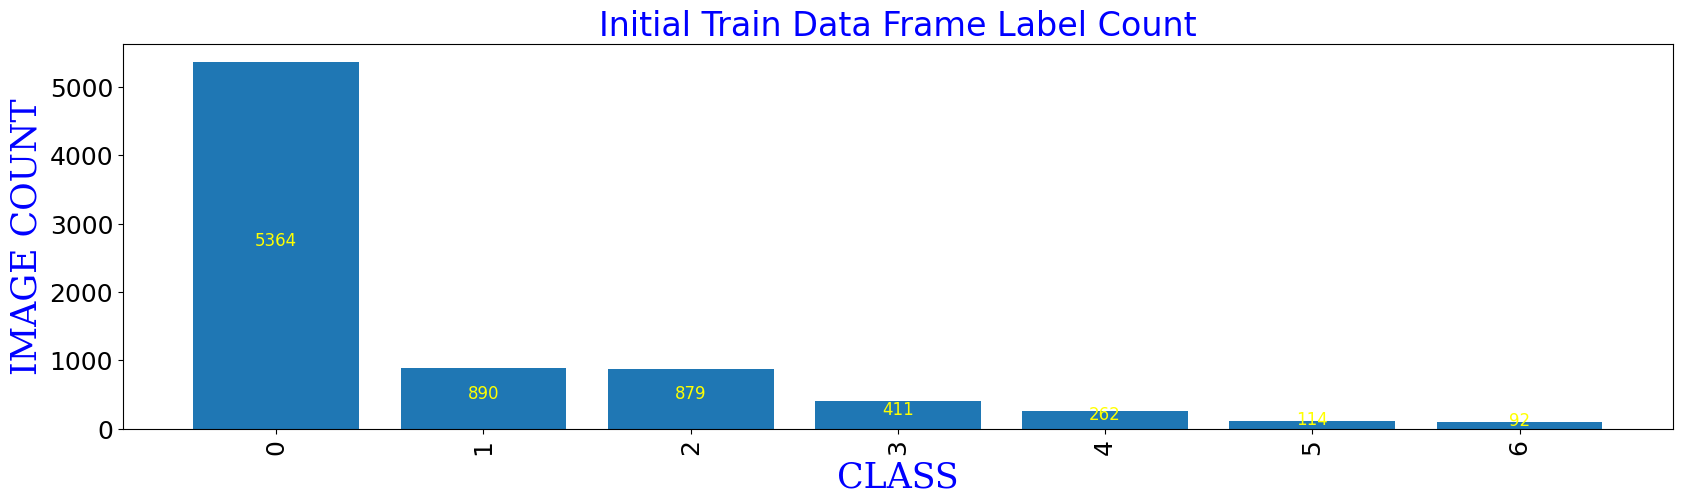

In [10]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5)) 
        form = {'family': 'serif', 'color': 'blue', 'size': 25} 
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')        
        plt.show()
        
count=train_df['labels'].value_counts()
plot_title='Initial Train Data Frame Label Count'
plot_label_count (train_df, plot_title)

## Make target classess balanced training dataset

In [11]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes= df[column].unique()
    print(classes)
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

In [12]:
max_samples=1000
min_samples= 2
column='labels'
train_df, classes, class_count= trim(train_df, max_samples, min_samples, column)

['2' '0' '3' '4' '1' '6' '5']
dataframe initially is of length  8012  with  7  classes
after trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  2
the trimmed dataframe now is of length  3648  with  7  classes


C:\Users\662262\AppData\Local\Temp\ipykernel_13360\2484357815.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)


In [13]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    def dummy(image):
        return image
        df=df.copy()
        
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)
                dest_path.replace("\\", "/")
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)

    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=1000
working_dir= root + "working/"
img_size = (310,640)
column='labels'
train_df=balance(train_df, n,column, working_dir, img_size)
#train_df['filepaths'] = train_df['filepaths'].str.replace("\\", "/")

Initial length of dataframe is  3648


augmenting class 5: 100%|██████████████████████████████████████████████████████████| 886/886 [00:29<00:00, 30.04files/s]

Total Augmented images created=  3352
Length of augmented dataframe is now  7000


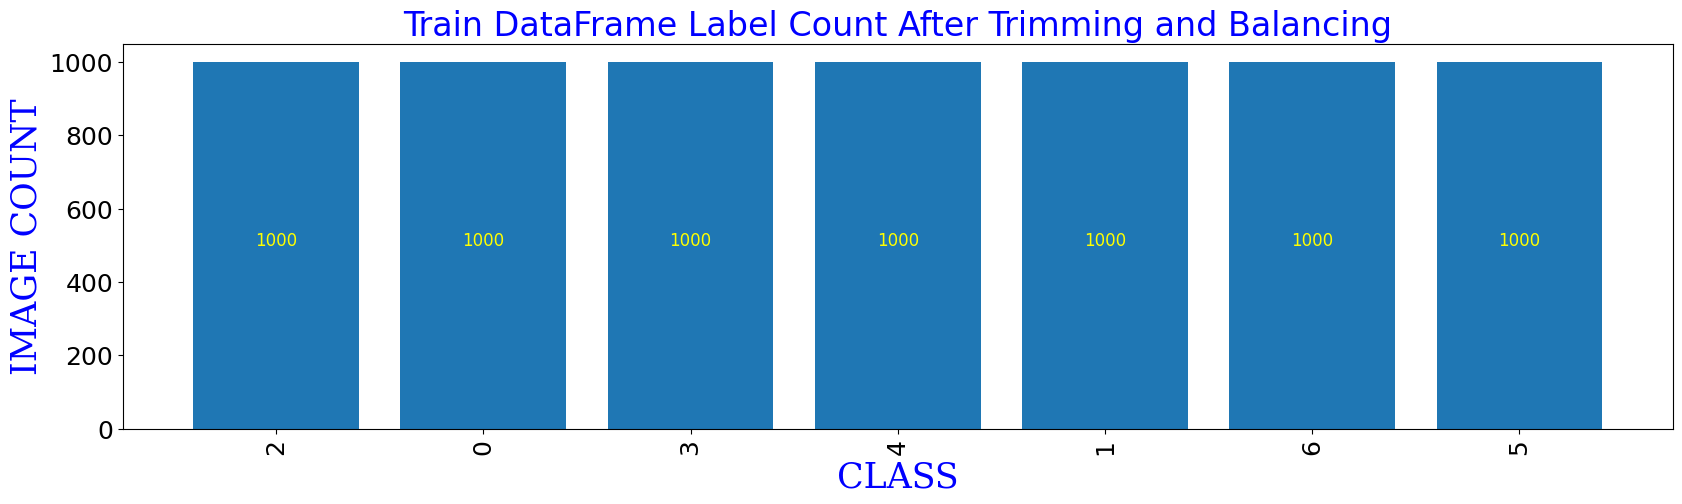

In [14]:
plot_title='Train DataFrame Label Count After Trimming and Balancing'
plot_label_count (train_df, plot_title)

## Make skin color types balanced dataset

In [15]:
num_skin_tone = 6

for i in range(1, num_skin_tone + 1, 1):
    rep = train_df[train_df["ita labels"] == i].sample(n=1, random_state=20)["filepaths"].values[0]
    rep_color = mean_skin_color(rep)[:3]
    if i == 6:
        for image_path in train_df["filepaths"]:
            color_space = "RGB"
            color_attributes = list(color_space)
            folder_index = i
            img_size = (310,640)
            
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            color_df = pd.DataFrame(img.reshape(-1, 3), columns=color_attributes)
            
            kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42)
            kmeans.fit(color_df)
            color_df["Cluster"] = kmeans.labels_
            centroids = kmeans.cluster_centers_
            
            # Create a mask for the darker cluster
            darker_cluster = 0 if is_darker(color_space, centroids[0], centroids[1]) else 1
            mask_darker = color_df["Cluster"] == darker_cluster
            
            # Create a mask with the same shape as the image
            mask_darker = mask_darker.values.reshape(img.shape[0], img.shape[1])
            mask_darker = mask_darker.astype(np.uint8)
            masked_img = cv2.bitwise_and(img, img, mask=mask_darker)        
            skin = np.any(masked_img != [0, 0, 0], axis=-1).astype(np.uint8)
            
            # get average bgr color
            ave_color = cv2.mean(img, mask=mask_darker)[:3]
            
            # compute difference colors and make into an image the same size as input
            diff_color = np.array(rep_color) - np.array(ave_color)
            
            # apply the color change only to the skin pixels
            new_img = img.copy()
            new_img[skin != 0, :] = (new_img[skin != 0, :] + diff_color).clip(0, 255)
            new_filepath = root + "working/skin/{0}/{1}".format(str(folder_index), os.path.basename(image_path))
            new_filepath.replace("\\", "/")
            new_img = Image.fromarray(new_img)
            new_img.save(new_filepath)
        
            # apply the color change all pixels
            new_img = img.copy()
            new_img[:] = (new_img[:] + diff_color).clip(0, 255)
            new_filepath = root + "working/all/{0}/{1}".format(str(folder_index), os.path.basename(image_path))
            new_filepath.replace("\\", "/")
            new_img = Image.fromarray(new_img)
            new_img.save(new_filepath)

In [17]:
skins = []
alls = []

for i in range(1, num_skin_tone + 1, 1):
    for index, r in train_df.iterrows():
        image_path = r["filepaths"]
        new_filepath = root + "working/skin/{0}/{1}".format(str(folder_index), os.path.basename(image_path))
        new_filepath.replace("\\", "/")
        skins.append((new_filepath, r["labels"]))
        new_filepath = root + "working/all/{0}/{1}".format(str(folder_index), os.path.basename(image_path))
        new_filepath.replace("\\", "/")
        alls.append((new_filepath, r["labels"]))

In [28]:
paths = [s[0] for s in alls]
labels = [s[1] for s in alls]

In [31]:
Fseries=pd.Series(paths, name='filepaths')
Lseries=pd.Series(labels, name='labels')   
aug_df=pd.concat([Fseries, Lseries], axis=1)         
train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
print('Length of augmented dataframe is now ', len(train_df))

Length of augmented dataframe is now  49000


In [33]:
train_df.to_csv(root + "working/train_df.csv", index=False)

In [34]:
valid_df.to_csv(root + "working/valid_df.csv", index=False)
test_df.to_csv(root + "working/test_df.csv", index=False)